# Example - "smoking" dataset

Let us try our hand at the "smoking" dataset, which is analyzed in a [post from calmcode.io](https://calmcode.io/smoking/the-dataset.html). Then, we cross-check the results.

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# changing working directory
import sys
sys.path.append("../")
%matplotlib inline

# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# better plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

## Data: "smoking"

Let us read the smoking dataset as it's provided in calmcode.io. We use the exact same cleaning procedure.

In [2]:
# rodando a função para gerar dados confounded
df_obs = pd.read_csv('https://calmcode.io/datasets/smoking.csv')

def clean_dataframe(dataf):
    return (dataf
            .assign(alive=lambda d: (d['outcome'] == 'Alive').astype(np.int))
            .assign(smokes=lambda d: (d['smoker'] == 'Yes').astype(np.int))
            .drop(['outcome','smoker'], axis=1))

df_obs = df_obs.pipe(clean_dataframe)
df_obs.head()

,age,alive,smokes
0,23,1,1
1,18,1,1
2,71,0,1
3,67,1,0
4,64,1,0


## Decision Trees as causal inference models

Let us do a quick refresher on the usage of the `DecisionTreeCounterfactual` method. First, we organize data in `X`, `W` and `y` format:

In [3]:
# organizing data into X, W and y
X = df_obs[['age']]
W = df_obs['smokes'].astype(int)
y = df_obs['alive']

Then, we fit the counterfactual model. As we're doing classification, we change the underlying `base_model`.

In [4]:
# importing cfml-tools
from cfml_tools.tree import DecisionTreeCounterfactual
from sklearn.tree import DecisionTreeClassifier

# instance of DecisionTreeCounterfactual
base_model = DecisionTreeClassifier(min_samples_leaf=50)
dtcf = DecisionTreeCounterfactual(model=base_model, save_explanatory=True)

# fitting data to our model
dtcf.fit(X, W, y)

We then predict the counterfactuals for all our individuals. We get the dataframe in the `counterfactuals` variable, which predicts outcomes for both `W = 0` and `W = 1`.

The methodology is as follows: we build a decision tree to solve a regression or classification problem from explanatory variables `X` to target `y`, and then compare outcomes for every treatment `W` at each leaf node to build counterfactual predictions. It yields good performance on fklearn's [causal inference problem](https://fklearn.readthedocs.io/en/latest/examples/causal_inference.html) out-of-the-box. Recursive partitioning performed by the tree will create clusters with individuals that are "identical enough" and enable us to perform counterfactual predictions.

In [5]:
# let us predict counterfactuals for these guys
counterfactuals = dtcf.predict(X)
counterfactuals.iloc[5:10]

y_hat          
W          0         1
id                    
5   0.918367  0.956522
6   0.750000  0.735294
7   0.000000  0.000000
8   0.960000  0.965517
9   0.960000  0.965517

We can see some NaNs in the dataframe. That's because for some individuals there are not enough treated or untreated samples at the leaf node to  estimate the counterfactuals, controlled by the parameter `min_sample_effect`. When this parameter is high, we are conservative, getting more NaNs but less variance in counterfactual estimation.

We check if the underlying model from `X`to `y` generalizes well, with reasonable AUC scores:

In [6]:
from sklearn.metrics import roc_auc_score, make_scorer

# validating model using 5-fold CV
cv_scores = dtcf.get_cross_val_scores(X, y, scoring=make_scorer(roc_auc_score))
print(cv_scores)

[0.8024055  0.8212165  0.81032677 0.74001536 0.79300428]


We want to keep this as high as possible, so we can trust that the model "strips away" the effects from `X` to `y`. 

Then we can observe the inferred treatment effect:

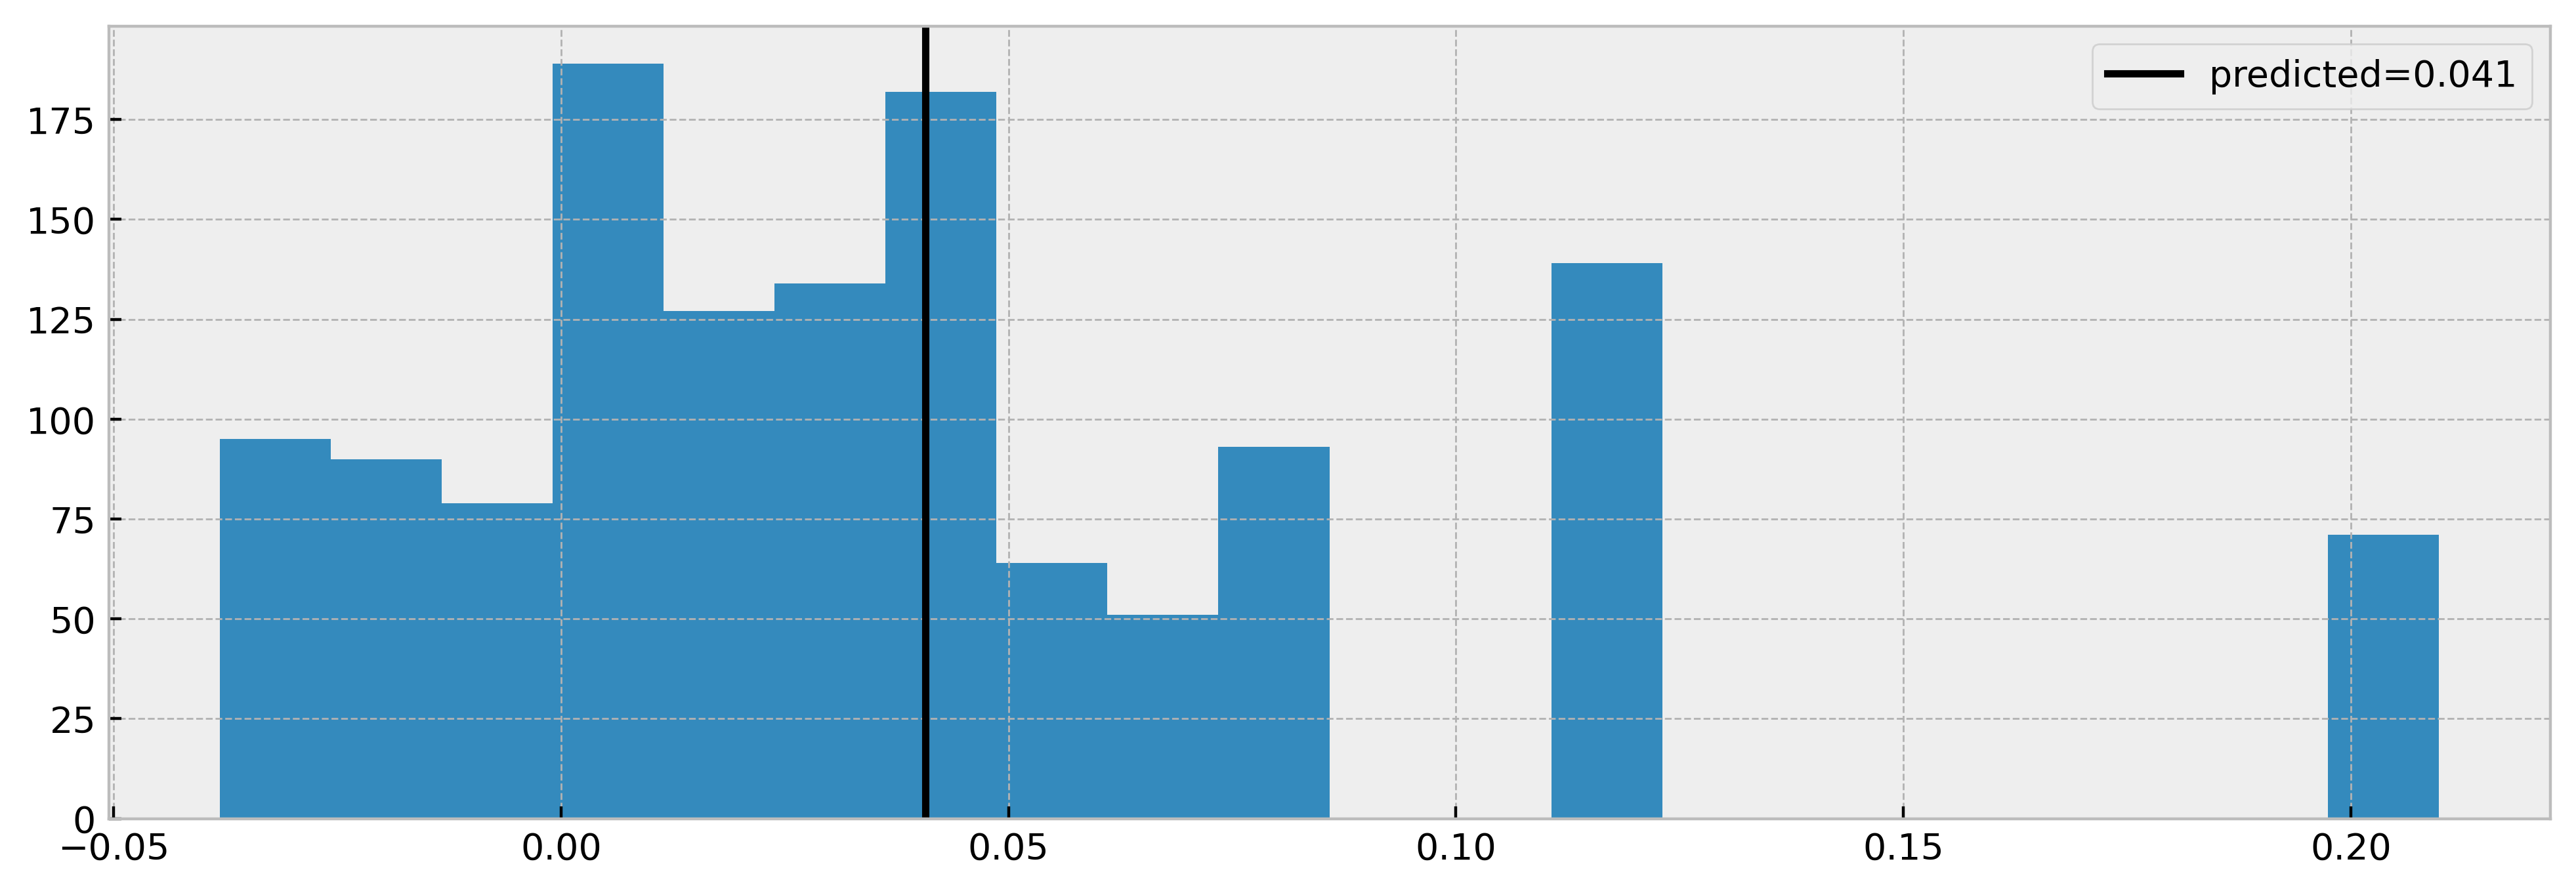

In [7]:
# importing matplotlib
import numpy as np
import matplotlib.pyplot as plt

# treatment effects
treatment_effects = counterfactuals['y_hat'][0] - counterfactuals['y_hat'][1]

# plotting effects
plt.style.use('bmh')
plt.figure(figsize=(12,4), dpi=200)
plt.hist(treatment_effects, bins=20);
plt.axvline(treatment_effects.mean(), color='k', label='predicted={}'.format(np.round(treatment_effects.mean(),3)))
plt.legend()
plt.show()

Which tells us that we get a bouns +4.1% to living longer if we do not smoke. Let us plot the counterfactual predictions by age:

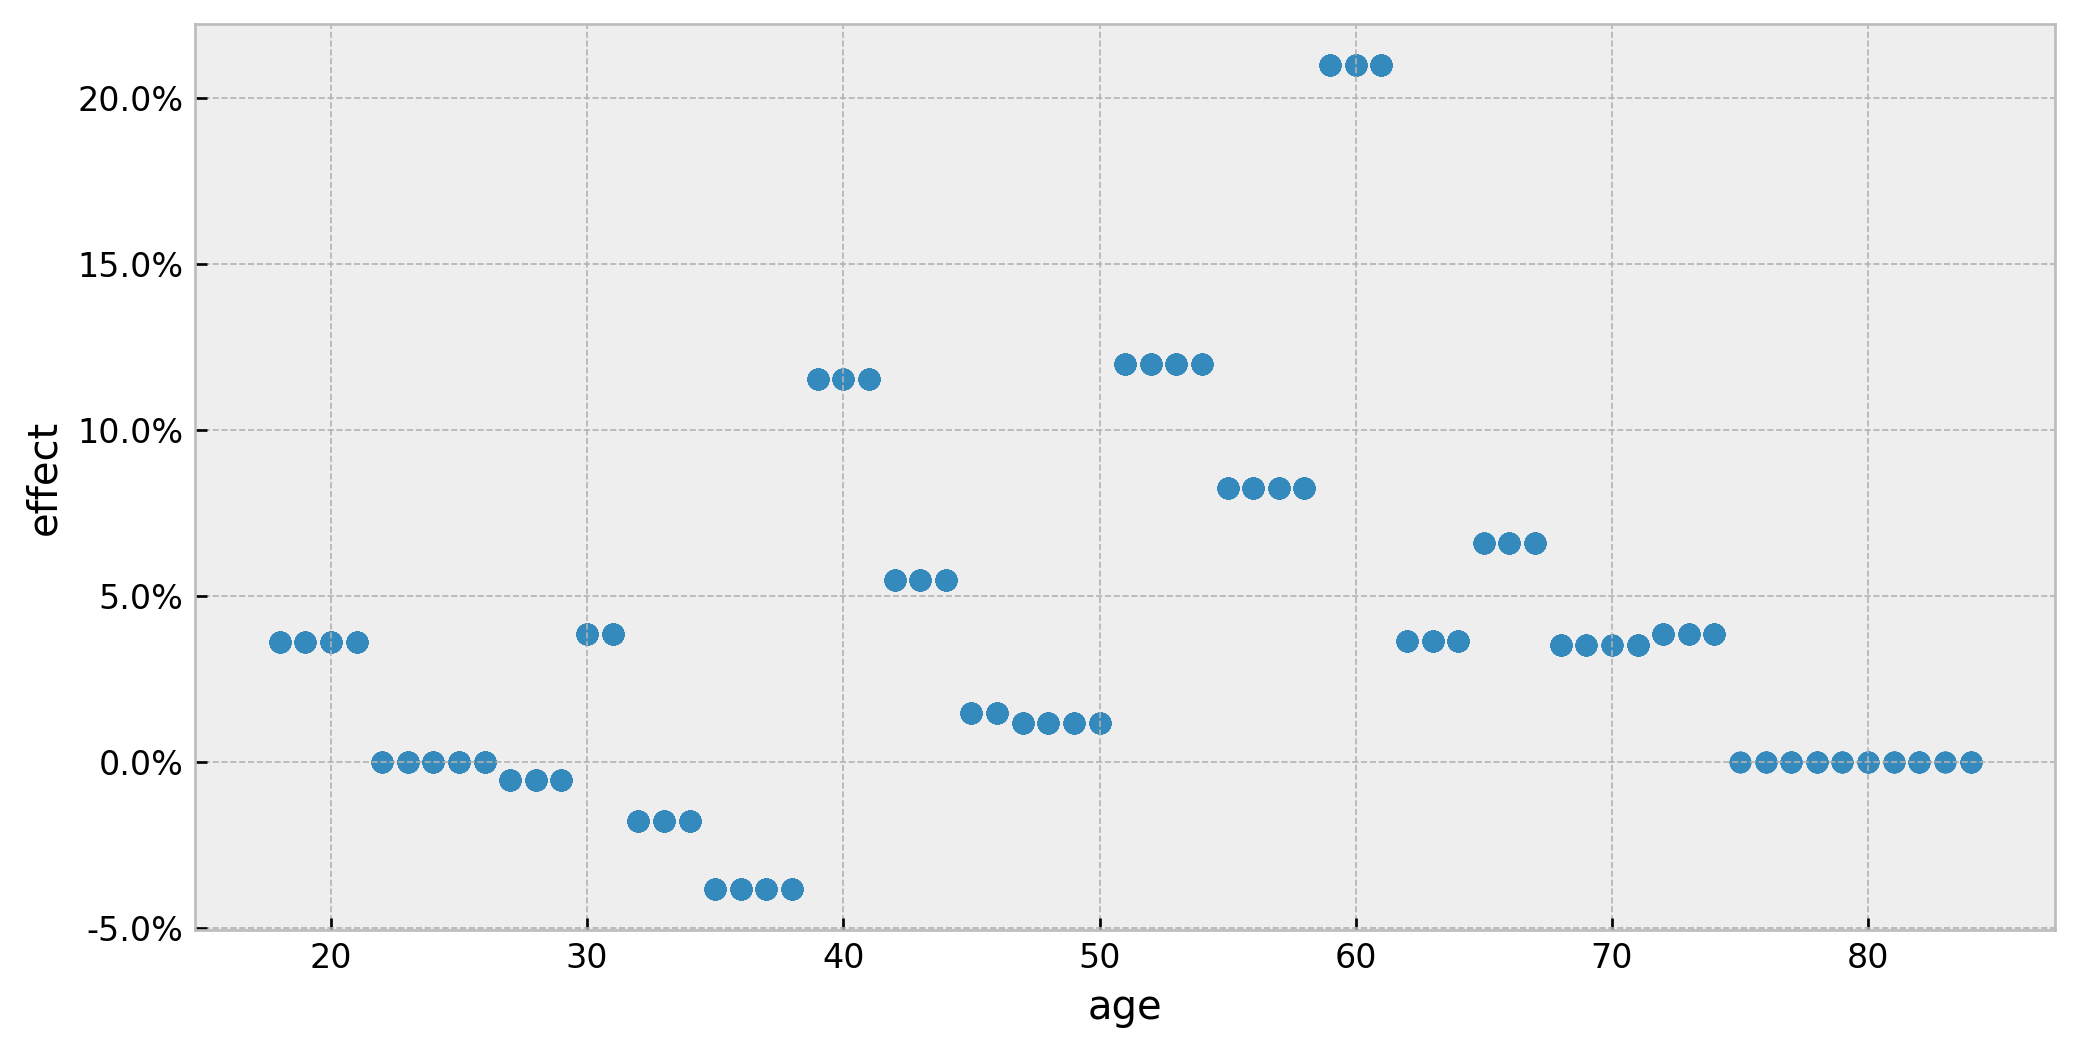

In [8]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(10,5), dpi=120)

plt.scatter(df_obs['age'], treatment_effects)
plt.xlabel('age'); plt.ylabel('effect')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

The effect seems to increase with age up until very old age.

## Digging deeper with *leaf diagnostics*

The `.run_leaf_diagnostics()` method provides valuable information to diagnose the countefactual predictions of the model. It performs analysis over the leaf nodes, testing if they really are the clusters containing the "identical enough" individuals we need.

We run the method and get the following dataframe:

In [9]:
# running leaf diagnostics
leaf_diagnostics_df = dtcf.run_leaf_diagnostics()
leaf_diagnostics_df.head()

avg_outcome           percentile_age           confounding_score
W              0         1              0         1                  
leaf                                                                 
5       0.973684  0.937500       0.026917  0.027136          0.504112
7       1.000000  1.000000       0.094506  0.098382          0.545484
9       0.960000  0.965517       0.166735  0.172768          0.600345
11      1.000000  0.961538       0.219780  0.221798          0.546526
12      0.958333  0.976190       0.277144  0.276056          0.515873

The dataframe provides a diagnostic on leaves with enough samples for counterfactual inference, showing some interesting quantities:

* average outcomes across treatments (`avg_outcome`) 
* explanatory variable distribution across treatments (`percentile_*` variables) 
* a confounding score for each variable, meaning how much we can predict the treatment from explanatory variables inside leaf nodes using a linear model (`confounding_score`)

The most important column is the `confounding_score`, which tells us if treatments are not randomly assigned within leaves given explanatory variables. It is actually the AUC of a linear model that tries to tell treated from untreated individuals within each leaf. Let us check how our model fares on this score:

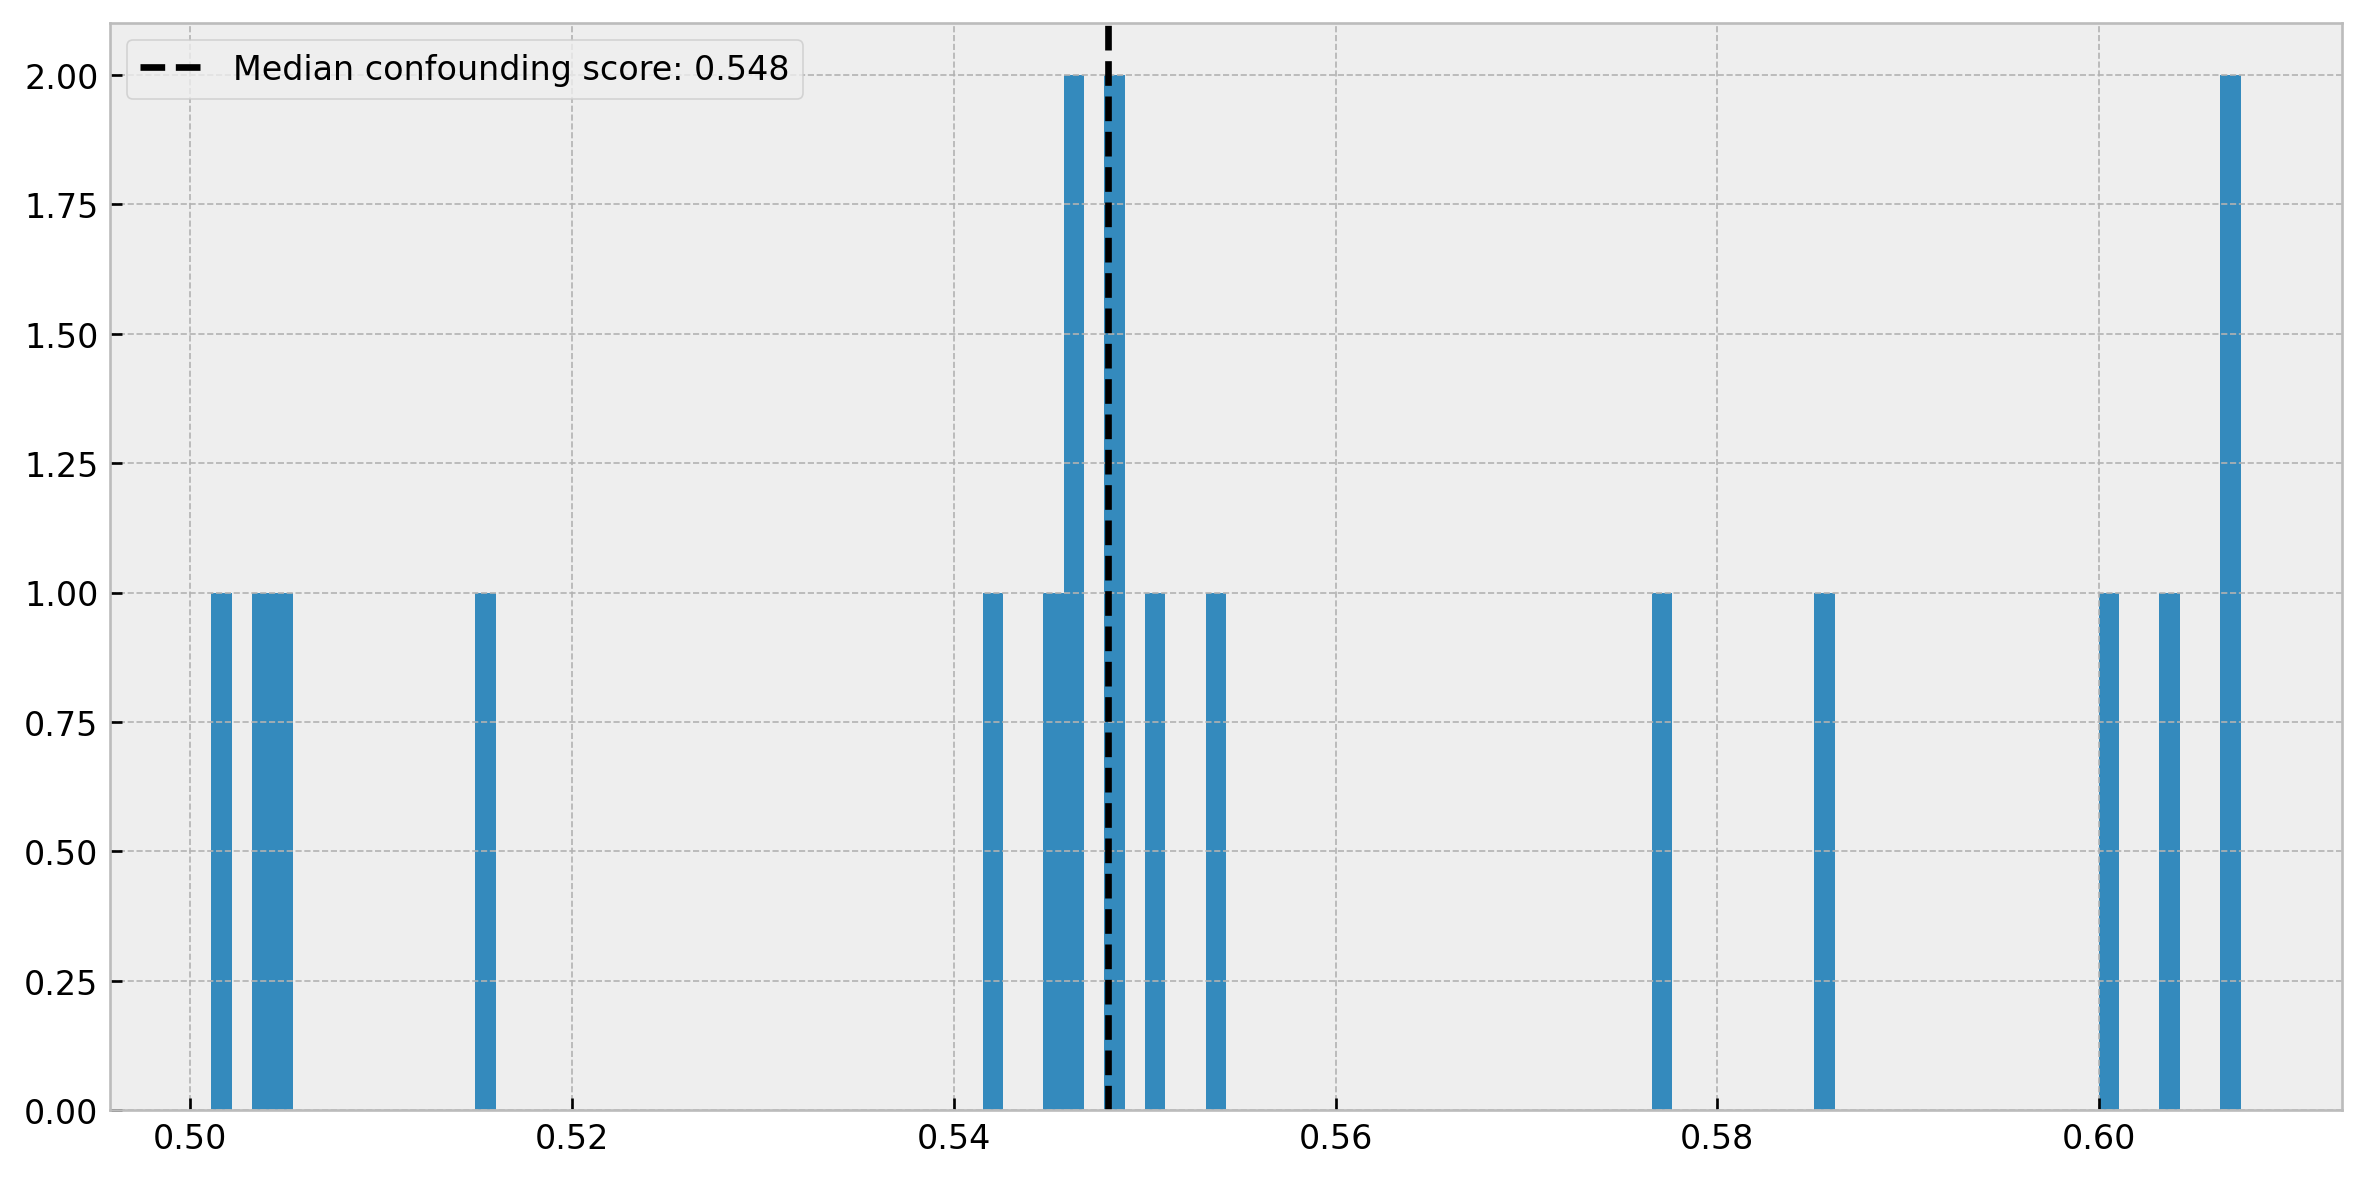

In [10]:
# avg confounding score
confounding_score_mean = leaf_diagnostics_df['confounding_score'].median()

# plotting
plt.figure(figsize=(12,6), dpi=120)
plt.axvline(
    confounding_score_mean,
    linestyle='dashed',
    color='black',
    label=f'Median confounding score: {confounding_score_mean:.3f}'
)
plt.hist(leaf_diagnostics_df['confounding_score'], bins=100);
plt.legend()

Cool. This is a good result. At most leaves treated and untreated individuals are virtually indistinguishable (AUC less than 0.6). We can show the confounding score and the treatment effects for each leaf in the same scatterplot, to double check if there's bias:

No handles with labels found to put in legend.


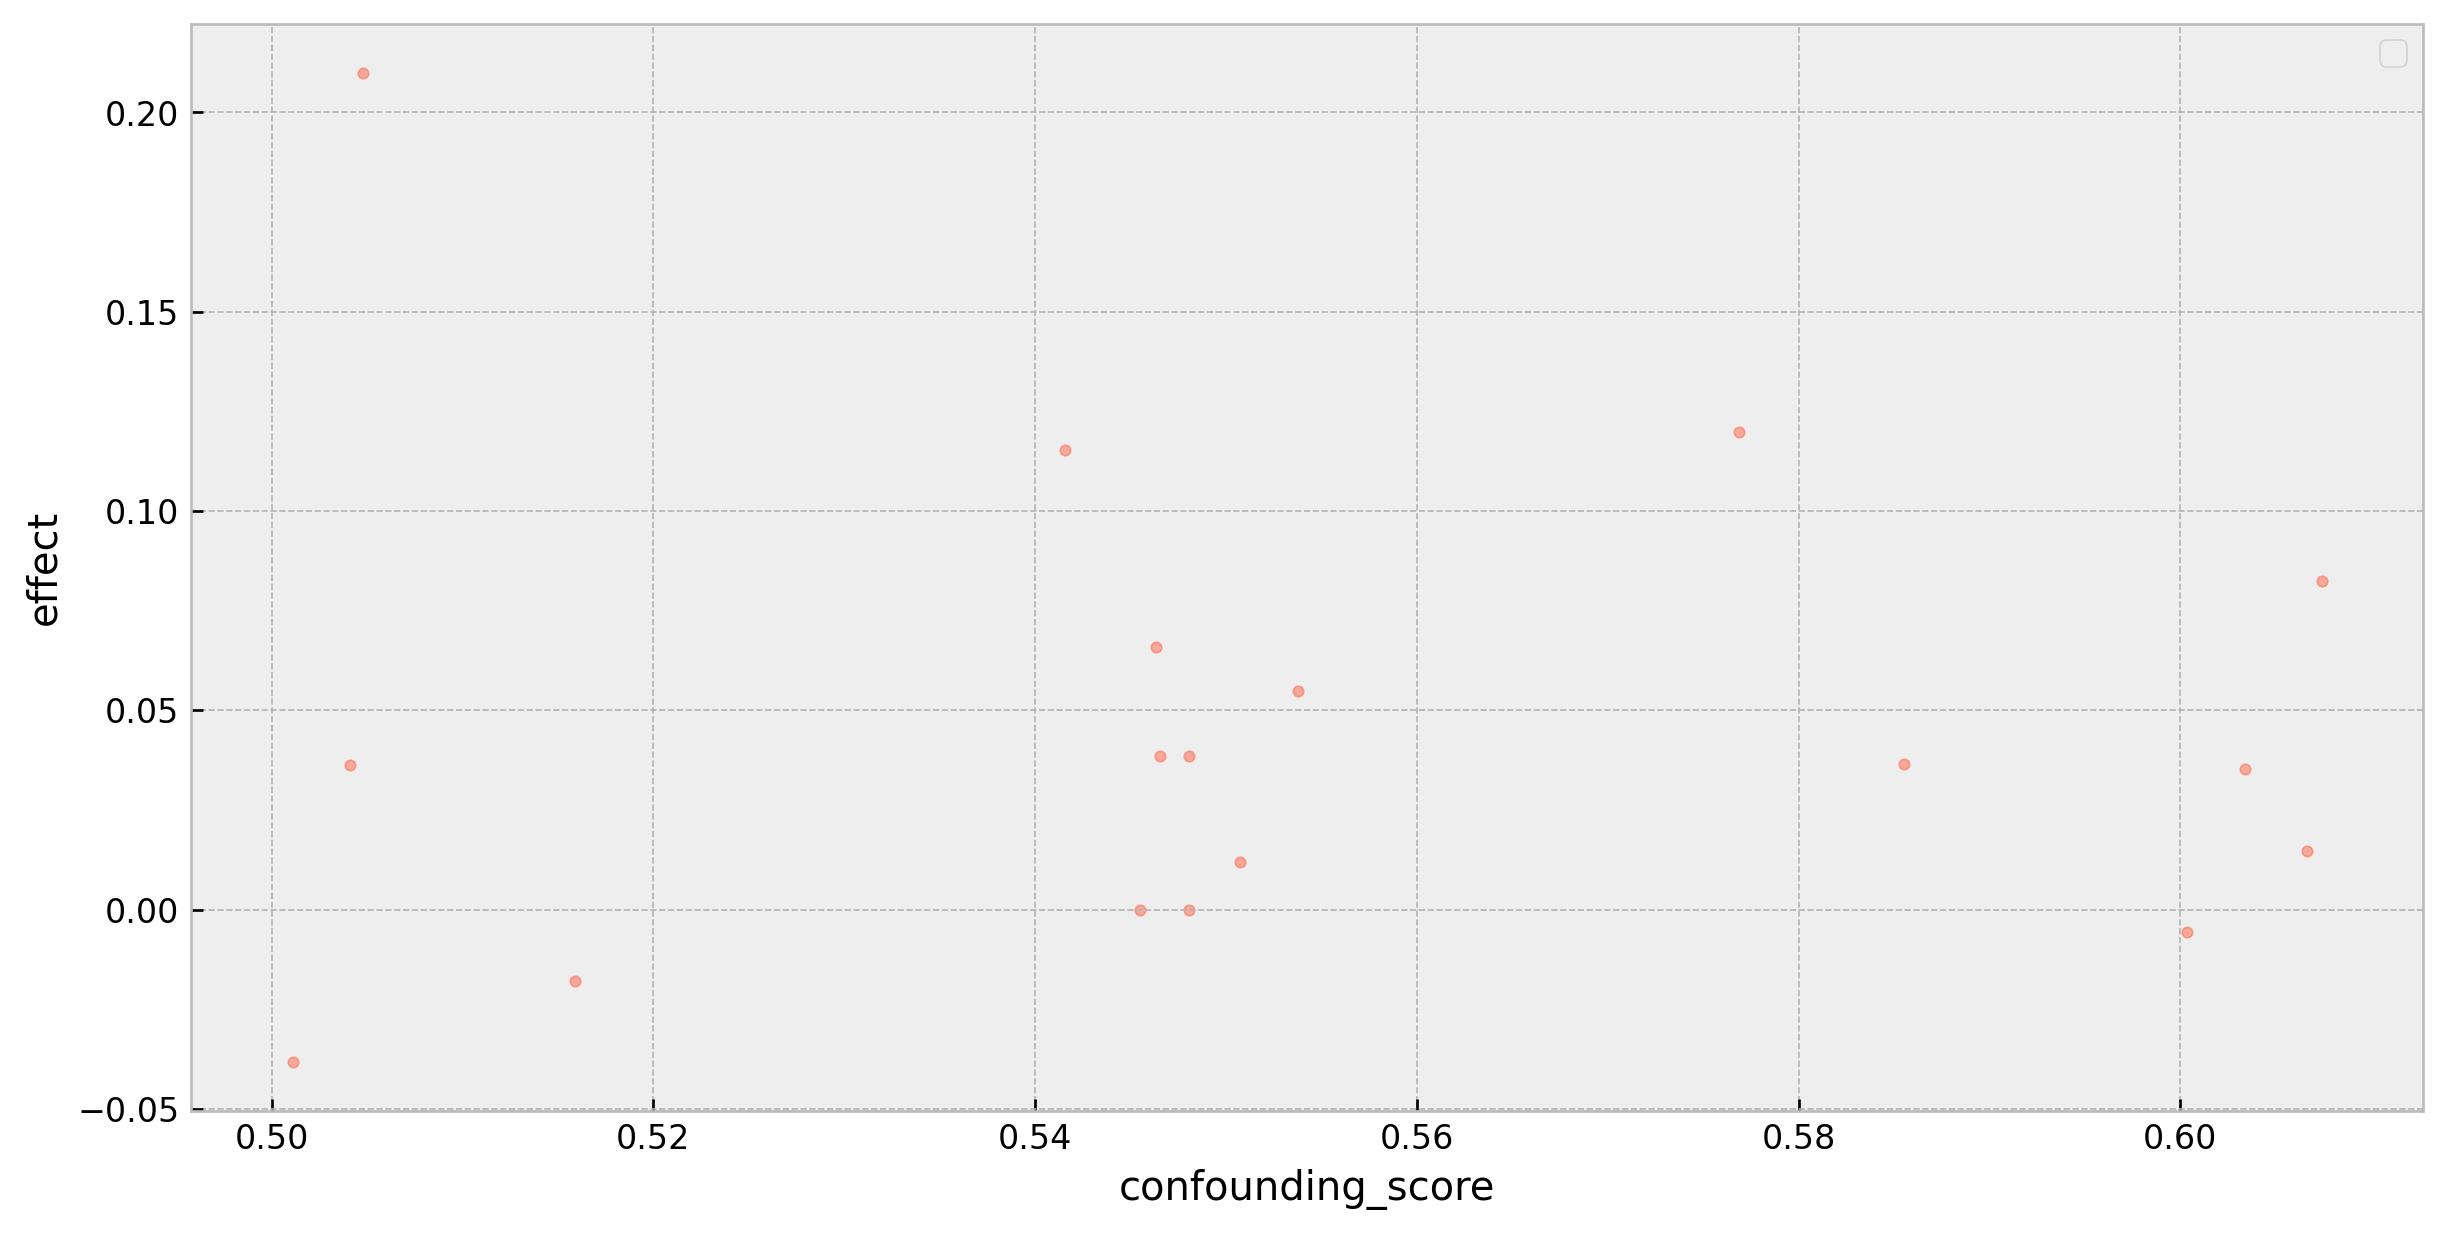

In [11]:
# adding effect to df
leaf_diagnostics_df = (
    leaf_diagnostics_df
    .assign(effect=lambda x: x['avg_outcome'][0] - x['avg_outcome'][1])
)

# real effect of fklearn's toy problem
real_effect = np.exp(-1)

# plotting
fig, ax = plt.subplots(1, 1, figsize=(12,6), dpi=120)

leaf_diagnostics_df.plot(
    x='confounding_score',
    y='effect',
    kind='scatter',
    color='tomato',
    s=10,
    alpha=0.5,
    ax=ax
)

plt.legend()

Seems ok as well, as the effect looks randomly distributed vs. the confounding score.